Fine-tuning

In [12]:
import torch
print("GPU available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

GPU available: True
Device: Tesla T4


In [13]:
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer

In [14]:
dataset = load_dataset("lex_glue", "scotus")
label_names = dataset['train'].features['label'].names
num_labels = len(label_names)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

In [17]:
model_name = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

In [21]:
import evaluate
import numpy as np

# Evaluation metric
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average="weighted")
    prec = precision.compute(predictions=predictions, references=labels, average="weighted")
    rec = recall.compute(predictions=predictions, references=labels, average="weighted")

    return {
        "accuracy": acc["accuracy"],
        "f1": f1_score["f1"],
        "precision": prec["precision"],
        "recall": rec["recall"]
    }

In [ ]:
# Training Arguments
training_args = TrainingArguments(
    report_to = None,
    output_dir="./legal-agent",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.06,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hyunjikim0208 (hyunjikim0208-ludwig-maximilianuniversity-of-munich) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.212700,0.971134,0.701429,0.668593,0.695071,0.701429
2,0.680500,0.979275,0.735714,0.710385,0.713011,0.735714
3,0.457500,1.055988,0.739286,0.717577,0.724347,0.739286


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=1875, training_loss=0.696397314453125, metrics={'train_runtime': 530.7951, 'train_samples_per_second': 28.259, 'train_steps_per_second': 3.532, 'total_flos': 3947055621120000.0, 'train_loss': 0.696397314453125, 'epoch': 3.0})

In [23]:
model.save_pretrained("fine_tuned_legal_agent")
tokenizer.save_pretrained("fine_tuned_legal_agent")

('fine_tuned_legal_agent/tokenizer_config.json',
 'fine_tuned_legal_agent/special_tokens_map.json',
 'fine_tuned_legal_agent/vocab.txt',
 'fine_tuned_legal_agent/added_tokens.json',
 'fine_tuned_legal_agent/tokenizer.json')

Evaluation

In [24]:
model = AutoModelForSequenceClassification.from_pretrained("fine_tuned_legal_agent")
tokenizer = AutoTokenizer.from_pretrained("fine_tuned_legal_agent")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [25]:
test_dataset = dataset["test"].map(preprocess_function, batched=True)

Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

In [26]:
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

In [27]:
from torch.utils.data import DataLoader
from tqdm import tqdm

test_loader = DataLoader(test_dataset, batch_size=8)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

100%|██████████| 175/175 [00:41<00:00,  4.17it/s]


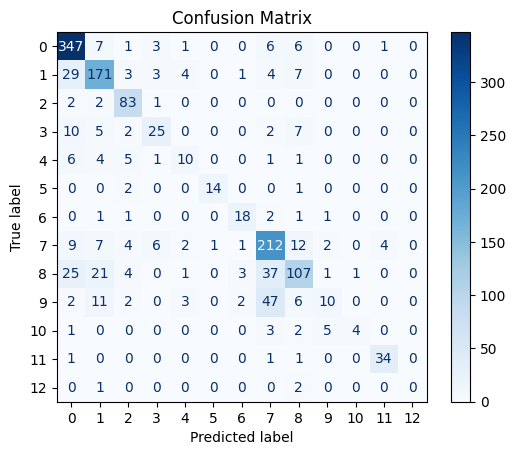

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import f1_score
import pandas as pd

f1_micro = f1_score(all_labels, all_preds, average='micro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

metrics_table = pd.DataFrame({
    "Metric": ["F1 Score (Micro)", "F1 Score (Macro)"],
    "Score": [f1_micro, f1_macro]
})

print(metrics_table.to_markdown(index=False))

| Metric           |    Score |
|:-----------------|---------:|
| F1 Score (Micro) | 0.739286 |
| F1 Score (Macro) | 0.606073 |
